In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def loadCleanData(fname):
    df = pd.read_csv(fname)
    
    # regularize capitalization and remove leading space in column headings
    fix_cols = {s : s.lower().strip() for s in df.columns.to_list()}
    df.rename(columns = fix_cols, inplace=True)
    
    # convert pixels from strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: [int(i) for i in x.split()])
    
    df.drop('usage', axis=1, inplace=True)
    
    return df

In [3]:
df = loadCleanData('data/icml_face_data.csv')
df.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [5]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [6]:
def displayImage(df, classes):
    index = np.random.randint(0, df.shape[0])
    img = np.array(df.iloc[index]['pixels'])
    n = int(np.sqrt(len(df.iloc[0]['pixels'])))
    img = img.reshape(n, n)
    
    plt.imshow(img, cmap='gray')
    plt.xlabel(classes[df.iloc[index]['emotion']])
    plt.show()
    

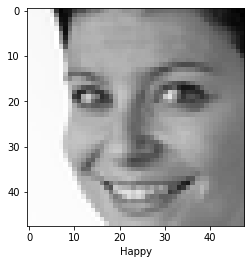

In [7]:
displayImage(df, classes)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df['pixels'],
                                                    df['emotion'],
                                                    test_size=0.2,
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28709,), (7178,), (28709,), (7178,))

In [10]:
clf = DummyClassifier()
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
print(f'Total baseline = {round(score * 100, 2)} %')

Total baseline = 16.9 %


C:\Users\A\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [11]:
x_train = np.vstack(x_train) / 255
x_test = np.vstack(x_test) / 255

n = int(np.sqrt(x_train.shape[1]))
x_train = x_train.reshape(x_train.shape[0], n, n, 1)
x_test = x_test.reshape(x_test.shape[0], n, n, 1)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [12]:
x_train.shape

(28709, 48, 48, 1)

In [40]:
model = Sequential([Conv2D(64, (3, 3), input_shape=x_train.shape[1:], activation='relu'),
                    MaxPool2D((2, 2)),
                    Conv2D(128, (3, 3), activation='relu'),
                    MaxPool2D((2, 2)),
                    Conv2D(256, (3, 3), activation='relu'),
                    MaxPool2D((2, 2)),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(7, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)             

In [41]:
stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

history = model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=100,
          batch_size=128,
          callbacks=[stop, checkpoint])

Train on 28709 samples, validate on 7178 samples
Epoch 1/100
28709/28709 [==============================] - 344s 12ms/sample - loss: 1.7352 - acc: 0.2961 - val_loss: 1.5787 - val_acc: 0.3774
Epoch 2/100
28709/28709 [==============================] - 344s 12ms/sample - loss: 1.4632 - acc: 0.4351 - val_loss: 1.3631 - val_acc: 0.4820
Epoch 3/100
28709/28709 [==============================] - 340s 12ms/sample - loss: 1.3144 - acc: 0.4986 - val_loss: 1.2868 - val_acc: 0.5074
Epoch 4/100
28709/28709 [==============================] - 340s 12ms/sample - loss: 1.2061 - acc: 0.5414 - val_loss: 1.2148 - val_acc: 0.5347
Epoch 5/100
28709/28709 [==============================] - 340s 12ms/sample - loss: 1.1193 - acc: 0.5790 - val_loss: 1.1808 - val_acc: 0.5515
Epoch 6/100
28709/28709 [==============================] - 341s 12ms/sample - loss: 1.0492 - acc: 0.6051 - val_loss: 1.1567 - val_acc: 0.5684
Epoch 7/100
28709/28709 [==============================] - 339s 12ms/sample - loss: 0.9731 - acc: 0

In [42]:
model.evaluate(x_test, y_test, verbose=0)

[1.1566876219188513, 0.5684035]

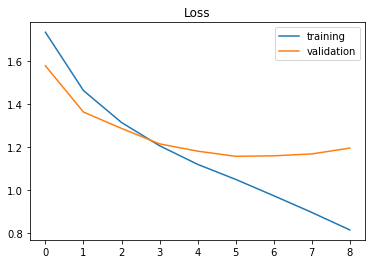

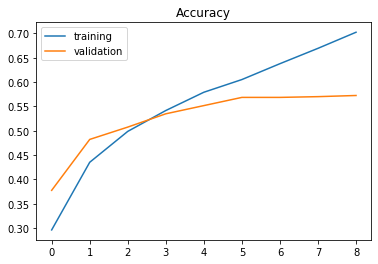

In [43]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

In [26]:
def tryRandomExample():
    index = np.random.randint(0, x_test.shape[0])
    img = x_test[index]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    best = np.argmax(pred[0])
    
    print(classes[best] == classes[y_test[index]])
    print(f'Predicted label: {classes[best]}\nConfidence: {round(pred[0][best] * 100, 2)} %')
    print(f'Actual label: {classes[y_test[index]]}')
    
    plt.imshow(np.squeeze(img[0], axis=-1), cmap='gray')
    plt.show()
    
    plt.bar(classes, pred[0])
    plt.show()
    
    

True
Predicted label: Sad
Confidence: 67.26 %
Actual label: Sad


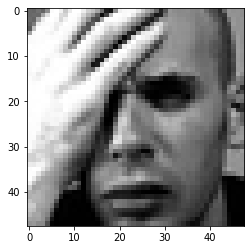

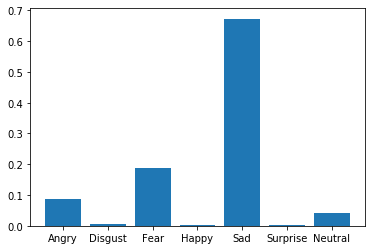

In [51]:
tryRandomExample()

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

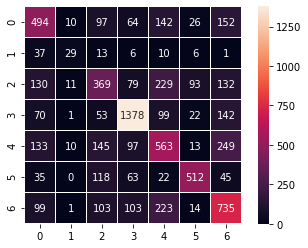

In [50]:
preds = model.predict(x_test)
y_pred = [np.argmax(pred) for pred in preds]
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d', linewidths=.2, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);
